# Google Cloud Integration

In [1]:
# sign in first !!!!
from __future__ import print_function 
from IPython.display import display
from datalab.context import Context
import datalab.bigquery as bq

context = Context.default()
print ('The current project is %s' % context.project_id)
# context.credentials.get_access_token()

The current project is test-hbase-spark


In [2]:
%%bash
ls
# curl --silent -H "Metadata-Flavor: Google" \
#   http://metadata/computeMetadata/v1/instance/service-accounts/default/email

BigQuery-Events.ipynb
BigQuery-over-BigTable.ipynb
BigQuery.ipynb
Datalab-Features.ipynb


# BigQuery

## Hello

In [3]:
%%sql
SELECT TOP(title, 10) as title, COUNT(*) as revisions
FROM [publicdata:samples.wikipedia]
WHERE wp_namespace = 0

title,revisions
George W. Bush,43652
List of World Wrestling Entertainment employees,30572
Wikipedia,29726
United States,27432
Michael Jackson,23245
Jesus,21768
Deaths in 2009,20814
World War II,20546
Britney Spears,20529
Wii,20225


## APIs

### Querying Data

In [4]:
# Create and run a SQL query
query = bq.Query('SELECT * FROM [cloud-datalab-samples:httplogs.logs_20140615] LIMIT 3').results()
print(type(query))
query

<class 'datalab.bigquery._query_results_table.QueryResultsTable'>


timestamp,latency,status,method,endpoint
2014-06-15 07:00:00.003772,122,200,GET,Interact3
2014-06-15 07:00:00.428897,144,200,GET,Interact3
2014-06-15 07:00:00.536486,48,200,GET,Interact3


### SQL

In [7]:
%%sql --module logspreview
# define a module - like a view
SELECT * FROM [cloud-datalab-samples:httplogs.logs_20140615] LIMIT 3

In [9]:
# Create a query using the SQL module defined above.
print(type(logspreview))
q = bq.Query(logspreview)

# Run the query, with caching turned off (for sample purposes only), so we're sure to be
# able to retrieve metadata, such as bytes processed from the resulting query job.
results = q.results(use_cache = False)
print(type(results))
results

<type 'module'>
<class 'datalab.bigquery._query_results_table.QueryResultsTable'>


timestamp,latency,status,method,endpoint
2014-06-15 07:00:00.003772,122,200,GET,Interact3
2014-06-15 07:00:00.428897,144,200,GET,Interact3
2014-06-15 07:00:00.536486,48,200,GET,Interact3


In [11]:
print(type(results))
# Inspecting the results, and the associated job
print (results.sql)
print (str(results.length) + ' rows')
print (str(results.job.bytes_processed) + ' bytes processed')

<class 'datalab.bigquery._query_results_table.QueryResultsTable'>
SELECT * FROM [cloud-datalab-samples:httplogs.logs_20140615] LIMIT 3
3 rows
24152138 bytes processed


In [12]:
# Inspect the programmatic representation.
# Converting the QueryResultsTable to a vanilla list enables viewing the literal data,
# as well as side-stepping the HTML rendering seen above.
list(results)

[{u'endpoint': 'Interact3',
  u'latency': 122,
  u'method': 'GET',
  u'status': 200,
  u'timestamp': datetime.datetime(2014, 6, 15, 7, 0, 0, 3772)},
 {u'endpoint': 'Interact3',
  u'latency': 144,
  u'method': 'GET',
  u'status': 200,
  u'timestamp': datetime.datetime(2014, 6, 15, 7, 0, 0, 428897)},
 {u'endpoint': 'Interact3',
  u'latency': 48,
  u'method': 'GET',
  u'status': 200,
  u'timestamp': datetime.datetime(2014, 6, 15, 7, 0, 0, 536486)}]

### Sampling with bq.Query

In [13]:
%%sql --module logs
SELECT * FROM [cloud-datalab-samples:httplogs.logs_20140615]

In [15]:
# Use a hash-based sampling strategy that hashes the timestamp and takes a 1% sample.
# By default, all fields are chosen, but a particular projection can be specified as well.
# Further, limit to 10, since, in this case, the only use of the sampled results is to display a table.
sampling = bq.Sampling.hashed('timestamp', percent=1, count=10, fields = ['timestamp', 'latency'])
sample = bq.Query(logs).sample(sampling = sampling)
sample

timestamp,latency
2014-06-15 07:00:05.449186,6
2014-06-15 07:00:05.908400,5
2014-06-15 07:00:09.078710,30
2014-06-15 07:00:18.609836,28
2014-06-15 07:00:18.861028,119
2014-06-15 07:00:25.316129,712
2014-06-15 07:00:28.423380,211
2014-06-15 07:00:46.074430,501
2014-06-15 07:00:51.734565,124
2014-06-15 07:00:53.029076,121


In [16]:
# Sampling is implemented using standard SQL constructs, and is performed in BigQuery,
# thereby limiting the results retrieved into the notebook.
print (sample.sql)

SELECT timestamp,latency FROM (SELECT * FROM [cloud-datalab-samples:httplogs.logs_20140615]) WHERE ABS(HASH(timestamp)) % 100 < 1 LIMIT 10


### Datasets and Tables

In [17]:
#list
datasets = bq.Datasets(project_id = 'cloud-datalab-samples')
for ds in datasets:
  display(ds.name)
  
sample_dataset = list(datasets)[1]
tables = sample_dataset.tables()
for table in tables:
  display (str(table.name.table_id) + ' ' + str(table.metadata.rows) + ' ' + str(table.metadata.size))
  
table = bq.Table('cloud-datalab-samples:httplogs.logs_20140615')
fields = map(lambda tsf: tsf.name, table.schema)
display(fields)

DatasetName(project_id=u'cloud-datalab-samples', dataset_id=u'appenginelogs')

DatasetName(project_id=u'cloud-datalab-samples', dataset_id=u'carprices')

DatasetName(project_id=u'cloud-datalab-samples', dataset_id=u'httplogs')

'testing 100 4586'

'training 417 19086'

[u'timestamp', u'latency', u'status', u'method', u'endpoint']

In [35]:
# create
# Create a new dataset (this will be deleted later in the notebook)
sample_dataset = bq.Dataset('sample')
sample_dataset.create(friendly_name = 'Sample Dataset', description = 'Created from Sample Notebook')
display(sample_dataset.exists())

# To create a table, we also need to create a schema.
# Its easiest to create a schema from some existing data, so this
# example demonstrates using an example object
sample_row = {
  'name': 'string value',
  'value': 0,
  'flag': True
}
sample_schema = bq.Schema.from_data([sample_row])
sample_table = bq.Table("sample.sample_table").create(schema = sample_schema, overwrite = True)
display(list(sample_dataset.tables()))

# Clear out sample resources
sample_dataset.delete(delete_contents = True)



True

[Table test-hbase-spark:sample.sample_table]

## Commands

In [10]:
%bigquery --help

usage: bigquery [-h]
                {sample,create,delete,dryrun,udf,execute,pipeline,table,schema,datasets,tables,extract,load}
                ...

Execute various BigQuery-related operations. Use "%bigquery <command> -h" for
help on a specific command.

positional arguments:
  {sample,create,delete,dryrun,udf,execute,pipeline,table,schema,datasets,tables,extract,load}
                        commands
    sample              Display a sample of the results of a BigQuery SQL
                        query. The cell can optionally contain arguments for
                        expanding variables in the query, if -q/--query was
                        used, or it can contain SQL for a query.
    create              Create a dataset or table.
    delete              Delete a dataset or table.
    dryrun              Execute a dry run of a BigQuery query and display
                        approximate usage statistics
    udf                 Create a named Javascript BigQuery UDF
    exec

In [18]:
%bigquery tables --help

usage: bigquery tables [-h] [-p PROJECT] [-d DATASET] [-f FILTER]

List the tables in a BigQuery project or dataset.

optional arguments:
  -h, --help            show this help message and exit
  -p PROJECT, --project PROJECT
                        The project whose tables should be listed
  -d DATASET, --dataset DATASET
                        The dataset to restrict to
  -f FILTER, --filter FILTER
                        Optional wildcard filter string used to limit the
                        results
None


### Listing BigQuery Resources

In [19]:
%bigquery datasets --project cloud-datalab-samples

In [39]:
%bigquery tables --dataset cloud-datalab-samples:httplogs

### Exploring Data

In [21]:
# schema
%bigquery schema --table cloud-datalab-samples:httplogs.logs_20140615

In [41]:
%bigquery sample --help

usage: bigquery sample [-h] [-q QUERY | -t TABLE | -v VIEW]
                       [-d {legacy,standard}] [-b BILLING] [-c COUNT]
                       [-m {limit,random,hashed,sorted}] [-p PERCENT]
                       [-f FIELD] [-o {ascending,descending}] [-P] [--verbose]

optional arguments:
  -h, --help            show this help message and exit
  -q QUERY, --query QUERY
                        the name of the query to sample
  -t TABLE, --table TABLE
                        the name of the table to sample
  -v VIEW, --view VIEW  the name of the view to sample
  -d {legacy,standard}, --dialect {legacy,standard}
                        BigQuery SQL dialect
  -b BILLING, --billing BILLING
                        BigQuery billing tier
  -c COUNT, --count COUNT
                        The number of rows to limit to, if sampling
  -m {limit,random,hashed,sorted}, --method {limit,random,hashed,sorted}
                        The type of sampling to use
  -p PERCENT, --percent PERCENT

In [22]:
%bigquery sample --table cloud-datalab-samples:httplogs.logs_20140615 --count 10 --field timestamp --method hashed

timestamp,latency,status,method,endpoint
2014-06-15 07:00:05.449186,6,302,GET,Other
2014-06-15 07:00:05.908400,5,302,GET,Other
2014-06-15 07:00:09.078710,30,405,GET,Interact2
2014-06-15 07:00:18.609836,28,200,GET,Other
2014-06-15 07:00:18.861028,119,200,GET,Other
2014-06-15 07:00:25.316129,712,200,GET,Interact3
2014-06-15 07:00:28.423380,211,404,GET,Other
2014-06-15 07:00:46.074430,501,200,GET,Other
2014-06-15 07:00:51.734565,124,200,GET,Other
2014-06-15 07:00:53.029076,121,405,GET,Interact2


### Visualizing Data

In [23]:
%%sql --module data
SELECT ROW_NUMBER() OVER (ORDER BY time) AS percentile, time
FROM (
  SELECT QUANTILES(LOG10(latency), 50) AS time
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
)

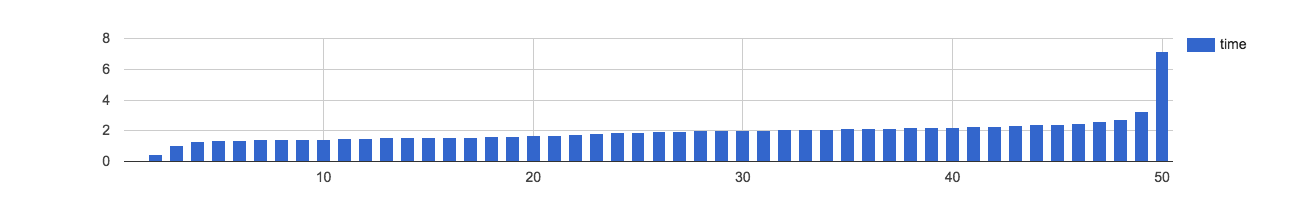

In [44]:
%chart columns --data data --fields percentile,time

# Parameterized

In [24]:
%%sql --dialect standard --module dt
SELECT TIMESTAMP(DATE($period)) as timestamp;

In [25]:
period = '2008-12-25'
q = bq.Query(dt, period= period)
results = q.results(use_cache = False)
results

timestamp
2008-12-25 00:00:00


In [26]:
! pip list --format=columns

Package                                         Version    
----------------------------------------------- -----------
appdirs                                         1.4.3      
avro                                            1.8.1      
backports-abc                                   0.5        
backports.shutil-get-terminal-size              1.0.0      
beautifulsoup4                                  4.5.3      
bleach                                          2.0.0      
brewer2mpl                                      1.4.1      
bs4                                             0.0.1      
cachetools                                      2.0.0      
certifi                                         2017.4.17  
configparser                                    3.5.0      
crcmod                                          1.7        
cycler                                          0.10.0     
datalab                                         1.0.1      
decorator                               